In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
# for QASVM
from classifiers.quantum import Qasvm_Mapping_4x2
from classifiers.quantum.qasvm import QASVM
from classifiers.optimizer import SPSA
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, NLocal, TwoLocal
from qiskit.providers.aer import QasmSimulator
from qiskit import IBMQ
# for logging & visualization
import logging
from classifiers.callback import SimplePMStorage, SimpleStorage
from torch.utils.tensorboard import SummaryWriter
from classifiers.visualization import Plot_Data, Plot_Log_From_SPSA, Plot_SVM, compare_svm_and_qasvm

writer = SummaryWriter()
storage = SimpleStorage(writer)

if IBMQ.active_account() is None:
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='reservations')
backend = provider.get_backend('ibmq_toronto')
backend

/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='reservations')>

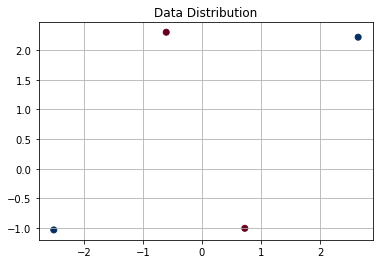

In [4]:
from classifiers.datasets.dataloader import Example_4x2
X, y = Example_4x2(True)()
Plot_Data(X, y).plot()

In [5]:
var_form = RealAmplitudes(2, reps=1)
quantum_instance = QuantumInstance(backend=backend, shots=2**13, seed_transpiler=0, optimization_level=2, basis_gates=backend.configuration().basis_gates, initial_layout=Qasvm_Mapping_4x2(backend=backend).layout, measurement_error_mitigation_cls=CompleteMeasFitter,)
qasvm = QASVM(X, y, var_form=var_form, quantum_instance=quantum_instance, C=None, k=0.1, option='Bloch_sphere').dual
print(qasvm.second_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, idle_wires=False)

72


global phase: 5π/8
              ┌────┐  ┌────────────────┐   ┌────┐  ┌────────┐     ┌───┐     ┌──────────┐┌────┐   ┌─────────┐                                                                                                                                                                                                                                                                                                                                                         ┌───┐                                                ┌───┐           ┌───┐                                                                                                                                                                   ░          
  i_0 -> 5 ───┤ √X ├──┤ RZ(θ_i[0] + π) ├───┤ √X ├──┤ RZ(3π) ├──■──┤ X ├──■──┤ RZ(3π/2) ├┤ √X ├───┤ RZ(π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├────────────────────────────────────────────────┤ X ├─────■─────┤ X ├──────■─────────────────────────■──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░──────────
              ├────┤  └────────────────┘   └────┘  └────────┘┌─┴─┐└─┬─┘┌─┴─┐└──────────┘├────┤┌──┴─────────┴───┐      ┌────┐      ┌────────┐                      ┌───┐                                                                                  ┌───┐             ┌───┐  ┌────────┐  ┌────┐  ┌────────────┐    ┌────┐    ┌───┐ ┌─────────────┐     ┌───┐     ┌─────────────┐     ┌───┐     ┌───────────────┐      ┌───┐           ┌───┐                     └─┬─┘           ┌───┐     ┌───┐     ┌───┐            └─┬─┘   ┌─┴─┐   └─┬─┘    ┌─┴─┐    ┌───┐┌──────────┐┌─┴─┐┌─────────┐┌────┐┌──────────┐                                                                                                   ░    ┌─┐   
 yi_0 -> 8 ───┤ √X ├─────────────────────────────────────────┤ X ├──■──┤ X ├─────■──────┤ √X ├┤ RZ(θ_i[2] + π) ├──────┤ √X ├──────┤ RZ(3π) ├────■─────────■───────┤ X ├─────────■───────────────────────■────────────────────────────────────────■───────┤ X ├───────■─────┤ X ├──┤ RZ(-π) ├──┤ √X ├──┤ RZ(3.1454) ├────┤ √X ├────┤ X ├─┤ RZ(0.62028) ├─────┤ X ├─────┤ RZ(-1.6377) ├─────┤ X ├─────┤ RZ(-0.014047) ├──────┤ X ├────────■──┤ X ├───────■───────────────■──────────■──┤ X ├──■──┤ X ├──■──┤ X ├─────■────────■─────┤ X ├─────■──────┤ X ├────┤ X ├┤ RZ(3π/2) ├┤ X ├┤ RZ(π/2) ├┤ √X ├┤ RZ(3π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────░────┤M├───
              ├────┤  ┌────────────────┐   ┌────┐  ┌────────┐└───┘     └───┘   ┌─┴─┐    ├────┤├────────────────┤      ├────┤      ├────────┤    │       ┌─┴─┐     └─┬─┘       ┌─┴─┐                     │                                        │       └─┬─┘       │     └─┬─┘  └────────┘  └────┘  └────────────┘    └────┘    └─┬─┘ └─────────────┘     └─┬─┘     └─────────────┘     └─┬─┘     └───────────────┘      └─┬─┘      ┌─┴─┐└─┬─┘     ┌─┴─┐      ┌──────────────┐┌─┴─┐└─┬─┘┌─┴─┐└─┬─┘  │  └─┬─┘     │              └───┘            └───┘    └─┬─┘└──────────┘└───┘└─────────┘└────┘└──────────┘                                                                                                   ░    └╥┘   
  i_1 -> 9 ───┤ √X ├──┤ RZ(θ_i[1] + π) ├───┤ √X ├──┤ RZ(3π) ├──────────────────┤ X ├────┤ √X ├┤ RZ(θ_i[3] + π) ├──────┤ √X ├──────┤ RZ(3π) ├────┼───────┤ X ├───────■─────────┤ X ├─────────────────────┼────────────────────────────────────────┼─────────┼─────────┼───────■──────────────────────────────────────────────────────┼─────────────────────────■─────────────────────────────┼────────────────────────────────■────────┤ X ├──■───────┤ X ├──────┤ RZ(0.027625) ├┤ X ├──

In [6]:
from torch.optim import Adam, SGD
from classifiers.quantum.pytorch import QASVM_model
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
import torch
from classifiers.callback import SimpleStorage

epochs = 2**10
last_avg = epochs/2**3
model = QASVM_model(qasvm)
optimizer = Adam(model.parameters(), lr=0.01)
theta_best = np.zeros(qasvm.num_parameters)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    output = model()
    output.backward()
    optimizer.step()
    with torch.no_grad():
        params = model.params.data
        cost = output
        storage(epoch, cost, np.array(list(map(lambda p:p.item(), params))))
        if epoch >= epochs - last_avg:
            theta_best += storage.params[epoch]/last_avg
            
writer.close()
qasvm.set_result(optimal_parameters=theta_best, num_optimizer_evals=epoch, eval_time=0)

  0%|          | 0/1024 [00:00<?, ?it/s]

FAILURE: Job id: 606230f08653252cbeae158f is cancelled. Re-submit the Qobj.


KeyboardInterrupt: 

In [ ]:
storage.plot()

In [ ]:
storage.plot_params()

In [ ]:
svm = BinarySVM(kernel=Kernel('SingleQubit'), mutation='REDUCED_QASVM', C=None, k=0.1)
svm.fit(X, y)
compare_svm_and_qasvm(svm=svm, qasvm=qasvm, repeat_for_qasvm=10)

In [ ]:
plt.plot(svm.alpha)
plt.plot(qasvm.alpha)